## Import Libraries

In [78]:
import pandas as pd
import numpy as np
import os
import glob
from IPython.display import HTML
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


#nltk.download('stopwords')

## Import Data

In [2]:
path = "C:\\Users\\Admin\\Jupyter_notebook\\Data Science Using Python\\Capston project\\aclImdb/"
train_positiveFiles = [x for x in os.listdir(path+"train/pos/") if x.endswith(".txt")]
train_negativeFiles = [x for x in os.listdir(path+"train/neg/") if x.endswith(".txt")]
train_unsupFiles = [x for x in os.listdir(path+"train/unsup/") if x.endswith(".txt")]

#testFiles = [x for x in os.listdir(path+"test/") if x.endswith(".txt")]

test_positiveFiles = [x for x in os.listdir(path+"test/pos/") if x.endswith(".txt")]
test_negativeFiles = [x for x in os.listdir(path+"test/neg/") if x.endswith(".txt")]
#test_unsupFiles = [x for x in os.listdir(path+"test/unsup/") if x.endswith(".txt")]


In [3]:
train_positiveReviews, train_negativeReviews, test_positiveReviews, test_negativeReviews, train_unsupReviews = [], [], [], [], []
for pfile in train_positiveFiles:
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        train_positiveReviews.append(f.read())
for nfile in train_negativeFiles:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        train_negativeReviews.append(f.read())
for unsupfile in train_unsupFiles:
    with open(path+"train/unsup/"+unsupfile, encoding="latin1") as f:
        train_unsupReviews.append(f.read())
#for tfile in testFiles:
#    with open(path+"test/"+tfile, encoding="latin1") as f:
#        testReviews.append(f.read())
        
for pfile in test_positiveFiles:
    with open(path+"test/pos/"+pfile, encoding="latin1") as f:
        test_positiveReviews.append(f.read())
for nfile in test_negativeFiles:
    with open(path+"test/neg/"+nfile, encoding="latin1") as f:
        test_negativeReviews.append(f.read())

In [4]:
imdb_train = pd.concat([
    pd.DataFrame({"review":train_positiveReviews, "label":1, "file":train_positiveFiles}),
    pd.DataFrame({"review":train_negativeReviews, "label":0, "file":train_negativeFiles}),
   # pd.DataFrame({"review":testReviews, "label":-1, "file":testFiles})
], ignore_index=True).sample(frac=1, random_state=1)
imdb_train.head()

,file,label,review
21492,6844_1.txt,0,"I have copy of this on VHS, I think they (The ..."
9488,7290_10.txt,1,After several extremely well ratings to the po...
16933,2740_1.txt,0,I still don't know why I forced myself to sit ...
12604,10094_1.txt,0,Mt little sister and I are self-proclaimed hor...
8222,6150_7.txt,1,I have personally seen many Disney movies in m...


In [5]:
imdb_test = pd.concat([
    pd.DataFrame({"review":test_positiveReviews, "label":1, "file":test_positiveFiles}),
    pd.DataFrame({"review":test_negativeReviews, "label":0, "file":test_negativeFiles}),
   # pd.DataFrame({"review":testReviews, "label":-1, "file":testFiles})
], ignore_index=True).sample(frac=1, random_state=1)
imdb_test.head()

,file,label,review
21492,6844_2.txt,0,A movie theater with a bad history of past gru...
9488,7290_10.txt,1,"""Here On Earth"" is a surprising beautiful roma..."
16933,2740_3.txt,0,I just watched Descent. Gawds what an awful mo...
12604,10094_4.txt,0,In a nutshell the movie is about a gang war in...
8222,6150_7.txt,1,"Instead of watching the recycled history of ""P..."


In [6]:
imdb_unsup = pd.concat([
    pd.DataFrame({"review":train_unsupReviews, "label":2, "file":train_unsupFiles}),
   # pd.DataFrame({"review":testReviews, "label":-1, "file":testFiles})
], ignore_index=True).sample(frac=1, random_state=1)
imdb_unsup.head()

,file,label,review
26247,33623_0.txt,2,It's a cheap production sequel to AMITYVILLE s...
35067,41561_0.txt,2,I was given this film by my uncle who had got ...
34590,41131_0.txt,2,I remember thinking Spongebob was the most stu...
16668,25001_0.txt,2,"So, I married an Axe murderer is not the sort ..."
12196,20978_0.txt,2,"As a Pagan, I half expected the overt Christia..."


In [7]:
print(imdb_train.shape)
print(imdb_test.shape)

(25000, 3)
(25000, 3)


## Data Preprocessing

In [9]:
#REMOVE STOPWORDS METHOD

In [10]:
def rem_sw(df):
    # Downloading stop words
    stop_words = set(stopwords.words('english'))

    # Removing Stop words from training data
 #   count = 0
    ps = PorterStemmer()
    #df['review'].astype(str).str
    df = df.astype(str).str.lower().str.replace('[^a-z]', ' ').str.split()
    df = df.apply(lambda x: ' '.join([ps.stem(word) for word in x if word not in stop_words]))

 #   for sentence in df['review']:
 #       sentence = [word for word in sentence.lower().split() if word not in stop_words]
 #       sentence = ' '.join(sentence)
 #       df.loc[count] = sentence
 #       count+=1
    return(df)


In [11]:
#REMOVING PUNCTUATIONS AND HTML TAGS METHOD

In [12]:
def rem_punc(df):
    count = 0
    tags_list = ['<p>' ,'</p>' , '<p*>',
             '<ul>','</ul>',
             '<li>','</li>',
             '<br>',
             '<strong>','</strong>',
             '<span*>','</span>',
             '<a href*>','</a>',
             '<em>','</em>']
    
    for tag in tags_list:
        df.replace(to_replace=tag, value='', regex=True, inplace=True)    
    
    for s in df:
        cleanr = re.compile('<.*?>')
        s = re.sub(r'\d+', '', s)
        s = re.sub(cleanr, '', s)
        s = re.sub("'", '', s)
        s = re.sub(r'\W+', ' ', s)
        s = s.replace('_', '')
        df.loc[count] = s
        count+=1
    return(df)


In [13]:
#APPLY LEMMATIZATION METHOD

In [14]:
def lemma(df):

    lmtzr = WordNetLemmatizer()

    count = 0
    stemmed = []
    
    for sentence in df:
        output = ''
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(lmtzr.lemmatize(word))
            output = ' '.join(stemmed)
        df.iloc[count] = output
        count+=1
        stemmed = []
    return(df)

In [15]:
#APPLY STEMMING METHOD

In [16]:
def stemma(df):
    
    stemmer = SnowballStemmer("english") #SnowballStemmer("english", ignore_stopwords=True)

    count = 0
    stemmed = []
    for sentence in df:
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(stemmer.stem(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [17]:
#PRINT ALL THE FEATURES AND PLOT METHOD

In [18]:
def print_feature(df):
    
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)

    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(20):
        print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

    # Plot the feature importances of the forest
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices[:100]],
           color="r", align="center")
    plt.xticks(range(100), sorted_features[:100], rotation=90)
    plt.xlim([-1, 100])
    plt.show()

    return()

In [19]:
#GET ALL THE FEATURES AND PLOT THEM METHOD

In [20]:
def get_feature(df, number):
    
    feature_list = []
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)
    
    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Create the feature list
    for f in range(number):
        feature_list.append(sorted_features[f][0])
    
    return(feature_list)

In [21]:
#GET BEST RF METHOD

In [22]:
def get_bestrf(X, y):
    parameters = [
        {
            "n_estimators":[5, 10, 20, 50, 100],
            "criterion":['gini', 'entropy']
        }
    ]

    best_clf = GridSearchCV(clf, parameters, scoring="accuracy", verbose=5, n_jobs=4)

    best_clf.fit(X, y)
    
    return(best_clf.best_estimator_.n_estimators, best_clf.best_estimator_.criterion)

# Phase 1: Data Cleaning & Preprocessing

In [23]:
print(imdb_train.shape)
imdb_train.head()

(25000, 3)


,file,label,review
21492,6844_1.txt,0,"I have copy of this on VHS, I think they (The ..."
9488,7290_10.txt,1,After several extremely well ratings to the po...
16933,2740_1.txt,0,I still don't know why I forced myself to sit ...
12604,10094_1.txt,0,Mt little sister and I are self-proclaimed hor...
8222,6150_7.txt,1,I have personally seen many Disney movies in m...


In [24]:
print(imdb_test.shape)
imdb_test.head()

(25000, 3)


,file,label,review
21492,6844_2.txt,0,A movie theater with a bad history of past gru...
9488,7290_10.txt,1,"""Here On Earth"" is a surprising beautiful roma..."
16933,2740_3.txt,0,I just watched Descent. Gawds what an awful mo...
12604,10094_4.txt,0,In a nutshell the movie is about a gang war in...
8222,6150_7.txt,1,"Instead of watching the recycled history of ""P..."


In [25]:
####Removing Stop words from training data

In [26]:
imdb_train['review'] = rem_sw(imdb_train['review'])
imdb_train.head()

,file,label,review
21492,6844_1.txt,0,copi vh think televis network play everi year ...
9488,7290_10.txt,1,sever extrem well rate point superb extrem ple...
16933,2740_1.txt,0,still know forc sit whole thing film worth mem...
12604,10094_1.txt,0,mt littl sister self proclaim horror movi buff...
8222,6150_7.txt,1,person seen mani disney movi lifetim though ab...


In [27]:
### Removing Stop words from testing data 

In [28]:
imdb_test['review'] = rem_sw(imdb_test['review'])
imdb_test.head()

,file,label,review
21492,6844_2.txt,0,movi theater bad histori past gruesom murder r...
9488,7290_10.txt,1,earth surpris beauti romant tale samantha boy ...
16933,2740_3.txt,0,watch descent gawd aw movi right bat depict la...
12604,10094_4.txt,0,nutshel movi gang war leon leader deuc start g...
8222,6150_7.txt,1,instead watch recycl histori pearl harbor noth...


In [29]:
#### Removing punctuations from Train set

In [30]:
imdb_train['review'] = rem_punc(imdb_train['review'])
imdb_train.head()

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,file,label,review
21492,6844_1.txt,0,prison cell four prison carrer young compani d...
9488,7290_10.txt,1,creator film made attempt introduc realiti plo...
16933,2740_1.txt,0,mayb seen one mani crime flick mayb take right...
12604,10094_1.txt,0,could good film abl watch hand held camera bou...
8222,6150_7.txt,1,japanes anim uniqu freedom anim tend abl come ...


In [31]:
###Removing punctuations from Test set 

In [32]:
imdb_test['review'] = rem_punc(imdb_test['review'])
imdb_test.head()

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,file,label,review
21492,6844_2.txt,0,feel need someon play role arbit public tast p...
9488,7290_10.txt,1,landscap battl andrzej wajda second era filmma...
16933,2740_3.txt,0,although embryo could potenti thought provok e...
12604,10094_4.txt,0,could breakout role valeria golino film instea...
8222,6150_7.txt,1,alistair simm wonder make good headmistress ro...


In [33]:
#### Stemming & Lammetization Train set

In [34]:
imdb_train['review'] = lemma(imdb_train['review'])
imdb_train['review'] = stemma(imdb_train['review'])

imdb_train.head()

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,file,label,review
21492,6844_1.txt,0,prison cell four prison carrer young compani d...
9488,7290_10.txt,1,creator film made attempt introduc realiti plo...
16933,2740_1.txt,0,mayb seen one mani crime flick mayb take right...
12604,10094_1.txt,0,could good film abl watch hand held camera bou...
8222,6150_7.txt,1,japan anim uniqu freedom anim tend abl come mo...


In [35]:
#### Stemming & Lammetization Test set

In [36]:
imdb_test['review'] = lemma(imdb_test['review'])
imdb_test['review'] = stemma(imdb_test['review'])

imdb_test.head()

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,file,label,review
21492,6844_2.txt,0,feel need someon play role arbit public tast p...
9488,7290_10.txt,1,landscap battl andrzej wajda second era filmma...
16933,2740_3.txt,0,although embryo could potenti thought provok e...
12604,10094_4.txt,0,could breakout role valeria golino film instea...
8222,6150_7.txt,1,alistair simm wonder make good headmistress ro...


In [37]:
#### Visualising the best Train features

Feature ranking:
feature 30276 : one (0.001554)
feature 5105 : br (0.001553)
feature 25604 : make (0.001551)
feature 24399 : like (0.001451)
feature 28250 : movi (0.001437)
feature 46536 : watch (0.001397)
feature 14632 : film (0.001389)
feature 17046 : good (0.001341)
feature 37453 : seen (0.001288)
feature 31699 : peopl (0.001281)
feature 47549 : would (0.001231)
feature 23016 : know (0.001191)
feature 13080 : end (0.001182)
feature 34529 : realli (0.001179)
feature 37437 : see (0.001170)
feature 38326 : show (0.001162)
feature 24834 : look (0.001156)
feature 282 : act (0.001155)
feature 13612 : even (0.001139)
feature 17356 : great (0.001115)


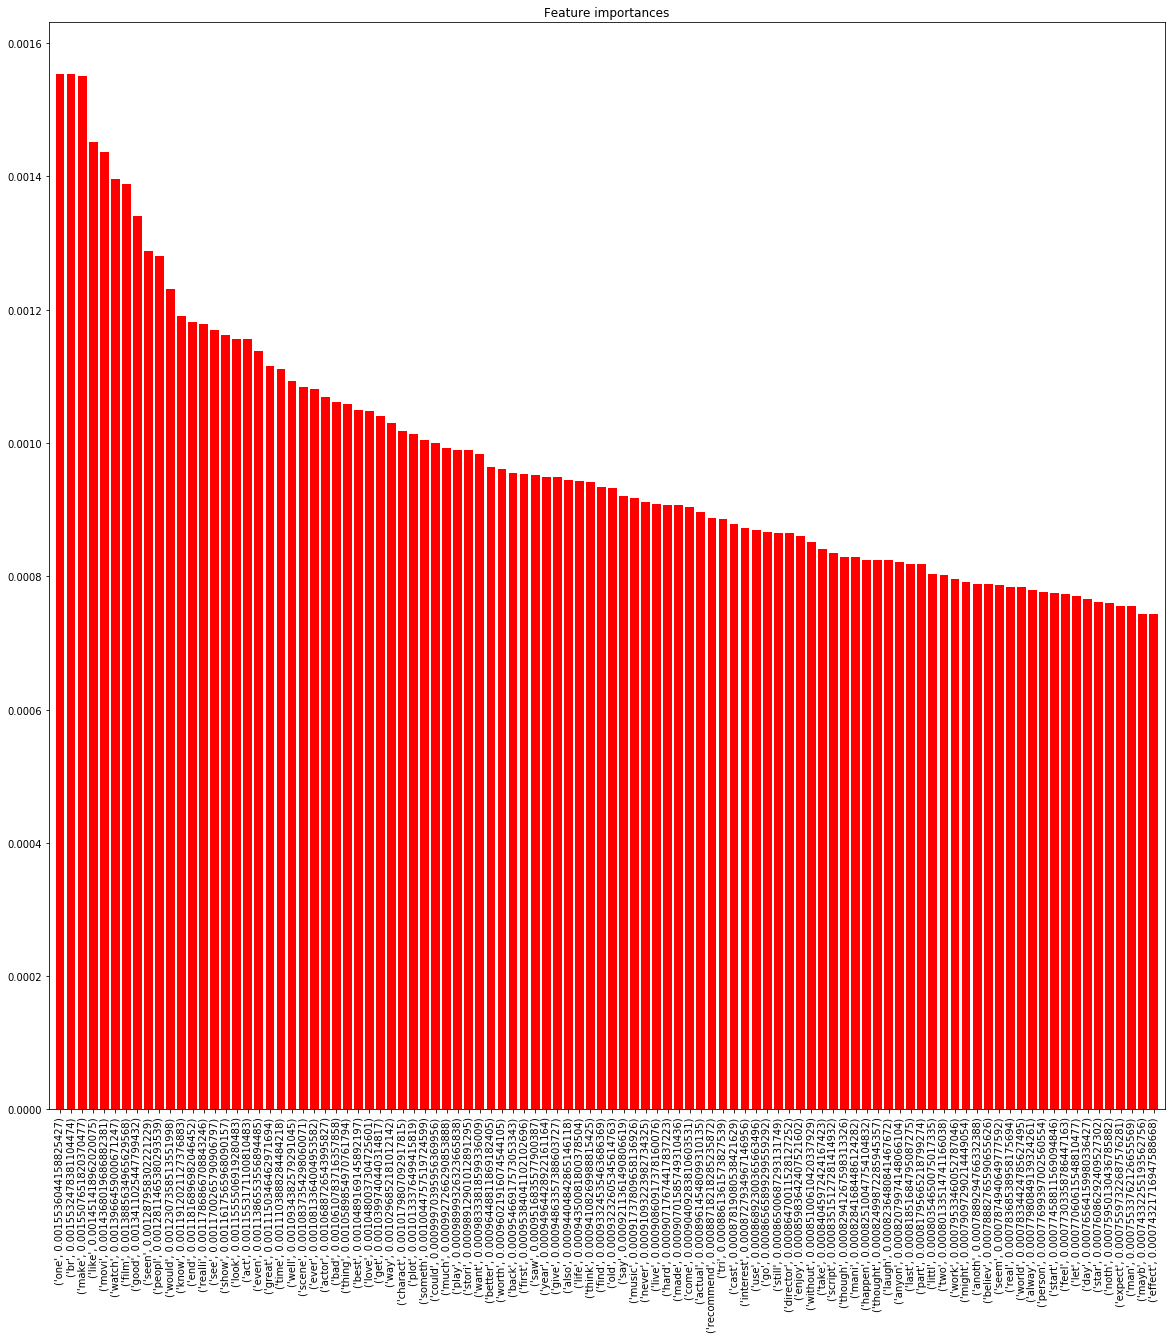

()

In [38]:
##  this graph is shows all features ranking of training data and how important they are
print_feature(imdb_train)

In [39]:
#### Visualising the best Test features

Feature ranking:
feature 5028 : br (0.001758)
feature 24201 : like (0.001721)
feature 27914 : movi (0.001678)
feature 45937 : watch (0.001592)
feature 14676 : film (0.001483)
feature 37014 : see (0.001420)
feature 29911 : one (0.001352)
feature 42324 : time (0.001305)
feature 300 : act (0.001294)
feature 25353 : make (0.001256)
feature 17090 : good (0.001238)
feature 46990 : would (0.001231)
feature 13642 : even (0.001225)
feature 7013 : charact (0.001223)
feature 34130 : realli (0.001208)
feature 32174 : plot (0.001197)
feature 42077 : think (0.001191)
feature 17413 : great (0.001184)
feature 40135 : stori (0.001179)
feature 25174 : made (0.001166)


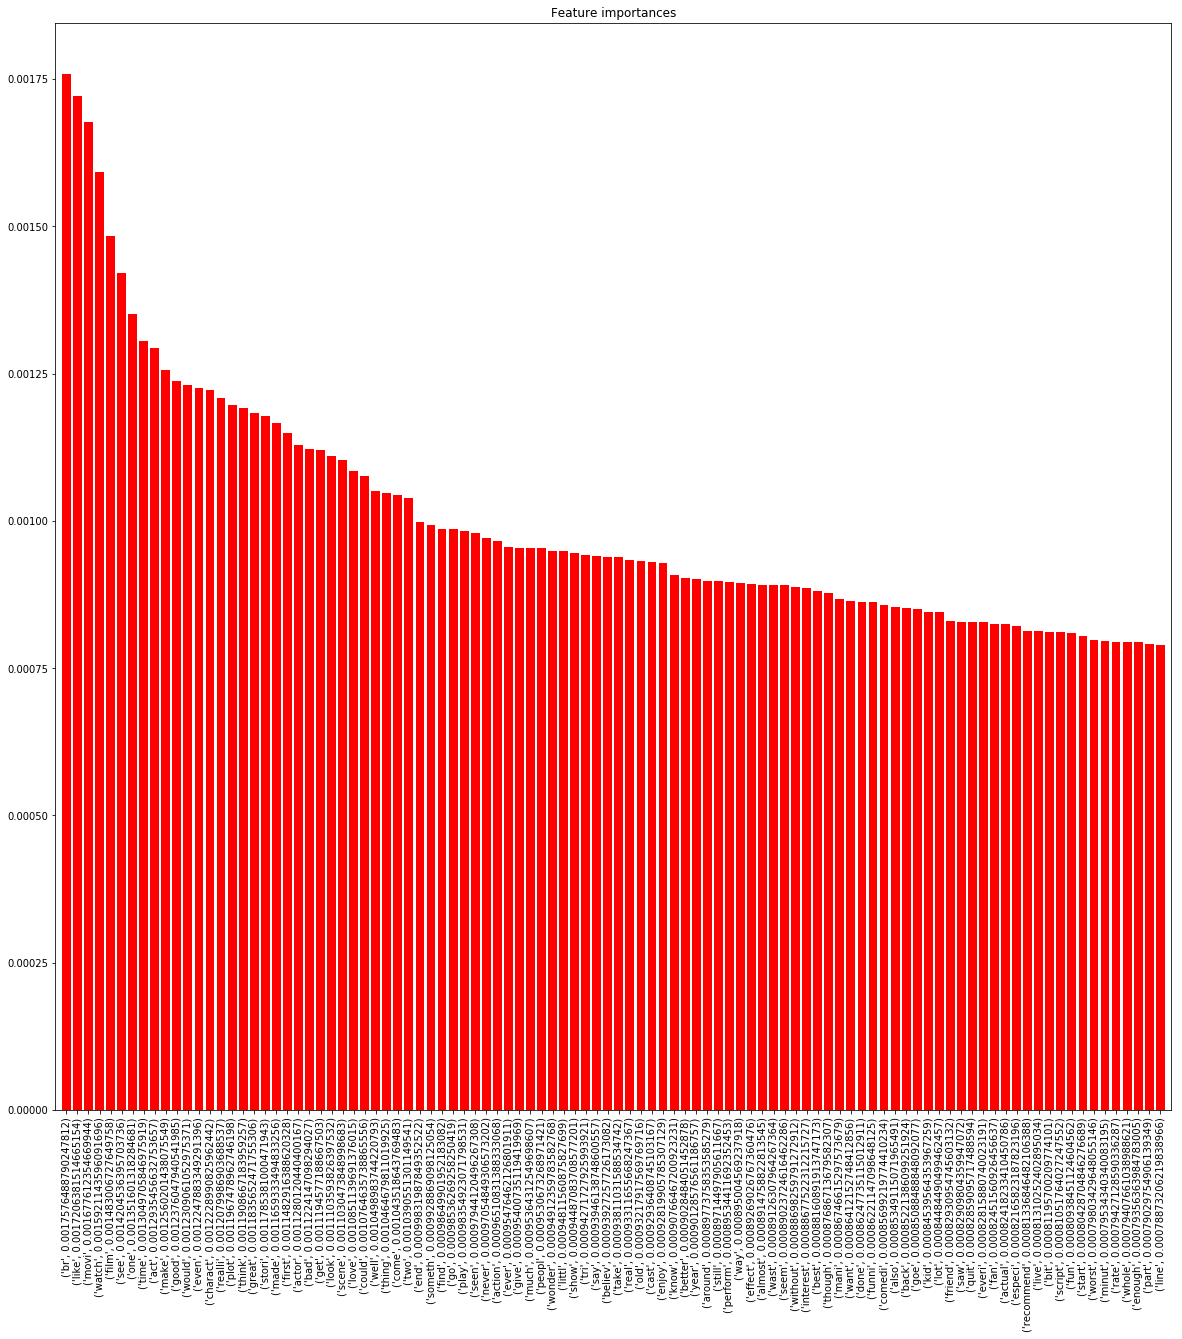

()

In [40]:
##  ##  this graph is shows all features ranking of testing data and how important they are

print_feature(imdb_test)

# Phase 2 Exploration

In [41]:
### Negative set frequency of train and test combined

In [42]:
# Creating a frequency dataframe of stemmed train and test data set
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Vectorizing negative reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_freq[df_freq.label.isin([0])].review)

# Visualising the high frequency words for negative set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
br,101074
movi,51920
film,47914
like,22655
time,16071
good,15062
make,15008
charact,14294
watch,13902
stori,12459


In [43]:
##### Positive set frequency of train and test combined 

In [44]:
# Creating a frequency dataframe of stemmed train and test data set
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Vectorizing pos reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_freq[df_freq.label.isin([1])].review)

# Visualising the high frequency words for positive set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
br,100880
movi,51365
film,47976
like,22557
time,15899
good,15137
make,15027
charact,14502
watch,13980
stori,12826


In [45]:
#### Lowest and highest frequency words

In [46]:
# Creating a frequency dataframe of stemmed train and test data set
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Vectorizing complete review set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_freq.review)

# Visualising the high and low frequency words for complete set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
print(df_freq.nlargest(1, 'frequency'), sep='\n')
print(df_freq.nsmallest(1, 'frequency'), sep='\t')

    frequency
br     201954
                            frequency
aaaaaaaaaaaahhhhhhhhhhhhhh          1


# Phase 3 Visualization 

In [47]:
### WordCloud Positive Train & Test set

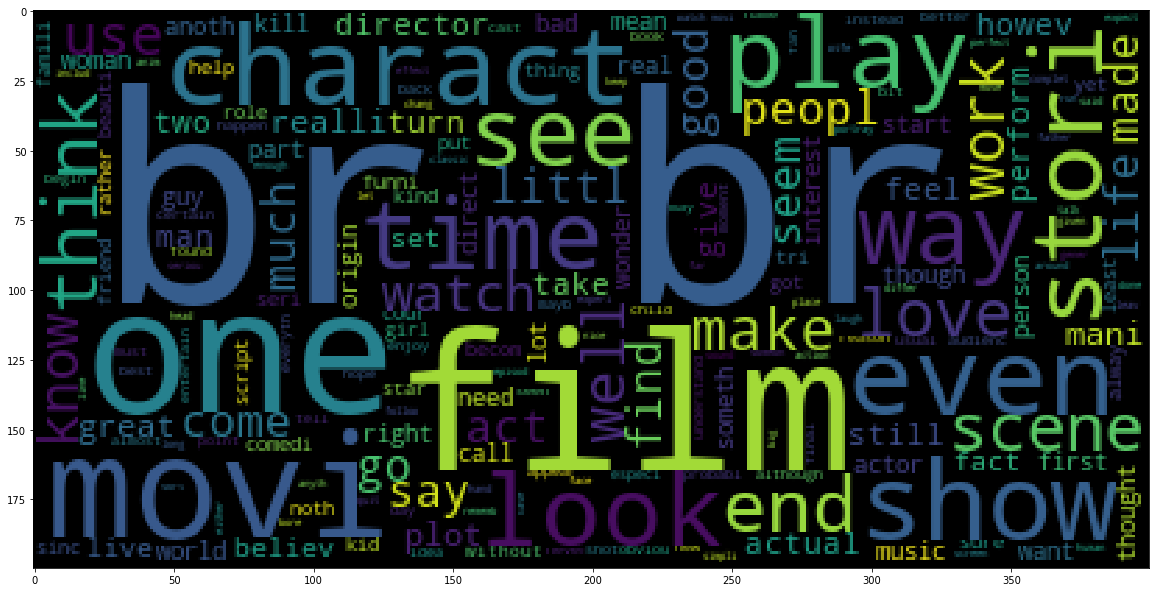

In [48]:
# Creating a list of train and test data to analyse
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)
imdb_list = df_freq["review"][df_freq.label.isin([1])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for positive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20,20))
plt.imshow(imdb_wordcloud)
plt.show()


In [49]:
### WordCloud Negative Train & Test set 

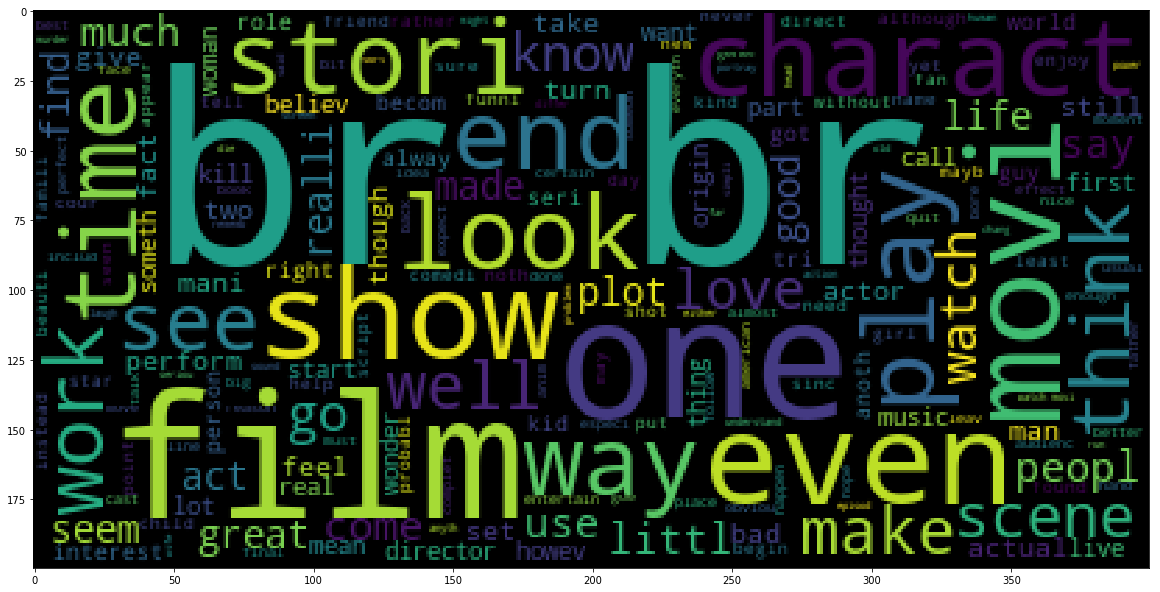

In [50]:
# Creating a list of train and test data to analyse
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)
imdb_list = df_freq["review"][df_freq.label.isin([0])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for negative words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

In [51]:
#### Histogram Positive Train & Test set

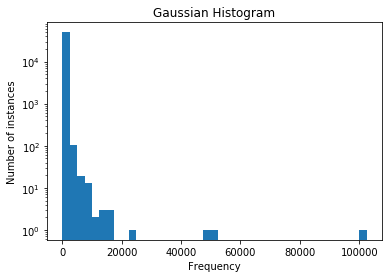

In [52]:
## this histogram shows how many times frequent positive words in training and test dataset


#Combining cleaned train and test data
df_freq = pd.concat([imdb_train, imdb_test],  ignore_index = True)

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin([1])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data[0], bins=range(min(data[0]),max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

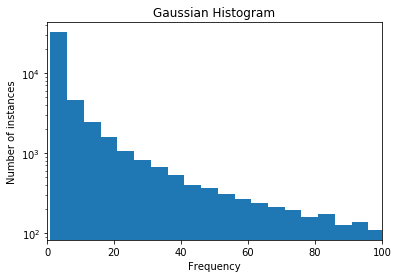

In [53]:
## this histogram shows less than 100 times frequent positive words in training and test dataset

# Zooming in on below 100 frequency words

zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.xlim(0, 100)
plt.show()

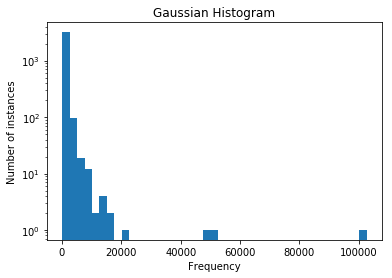

In [54]:
## this histogram shows grater than 100 times frequent positive words in training and test dataset

# Having a look at above 100 frequency words more closely

zoom_data = [f for f in data[0] if f > 100]
binwidth = 2500
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

In [55]:
### Histogram Negative Train & Test set

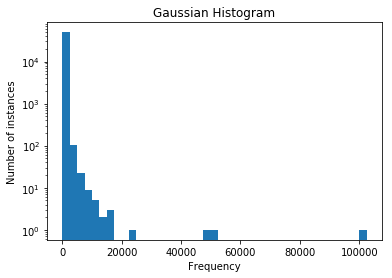

In [56]:
## this histogram shows how many times frequent Negative words in training and test dataset


#Combining cleaned train and test data
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_neg = hist_cv.fit_transform(df_freq[df_freq.label.isin([0])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_neg.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

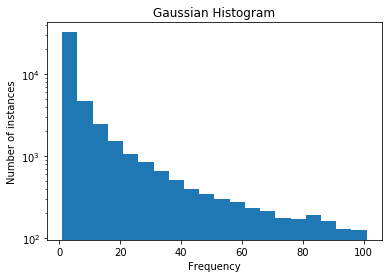

In [57]:
## this histogram shows less than 100 times frequent Negative words in training and test dataset


# Having a look at less than 100 frequency words more closely
zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

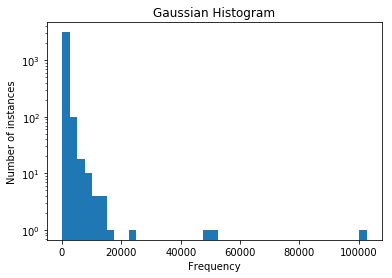

In [58]:
## this histogram shows grater than 100 times frequent Negative words in training and test dataset


# Having a look at above 100 frequency words more closely

zoom_data = [f for f in data[0] if f > 100]
binwidth = 2500
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

In [59]:
###Visualising after feature selection

In [60]:
##Creating the required dataset
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

word_list = get_feature(df_freq, 1000)

# Removing non prefered words from training and test combined data
count = 0
for sentence in df_freq['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    df_freq.loc[count, 'review'] = sentence
    count+=1

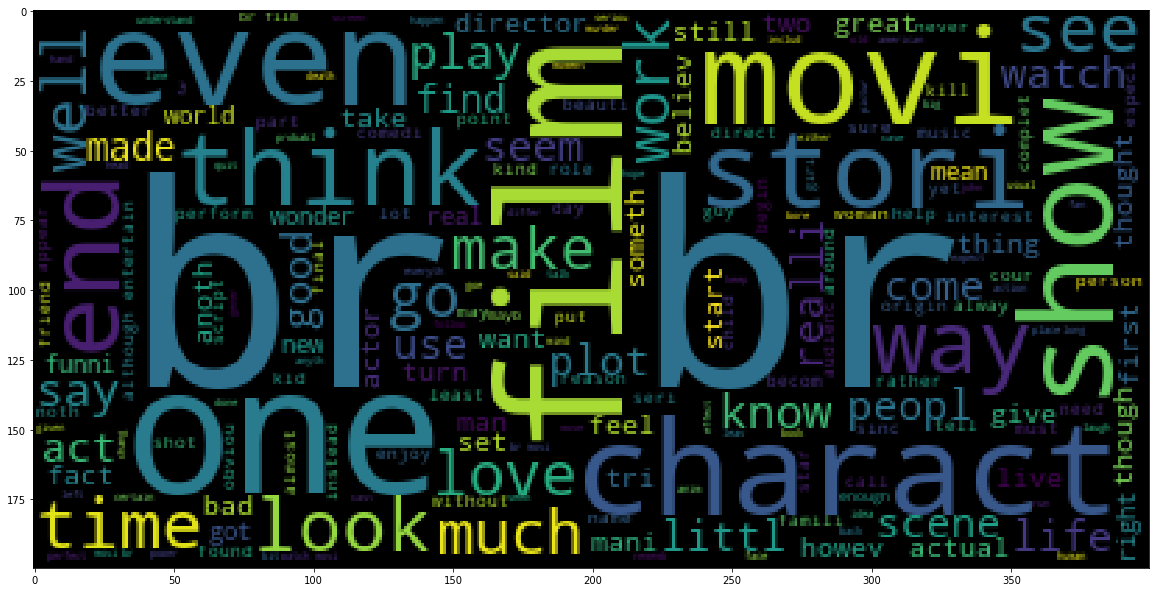

In [61]:
#### WordCloud Positive Train & Test set post feature selection 
# Creating a list of train and test data to analyse
imdb_list = df_freq["review"][df_freq.label.isin([1])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for psitive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20,20))
plt.imshow(imdb_wordcloud)
plt.show()

In [62]:
#### WordCloud Negative Train & Test set post feature selection

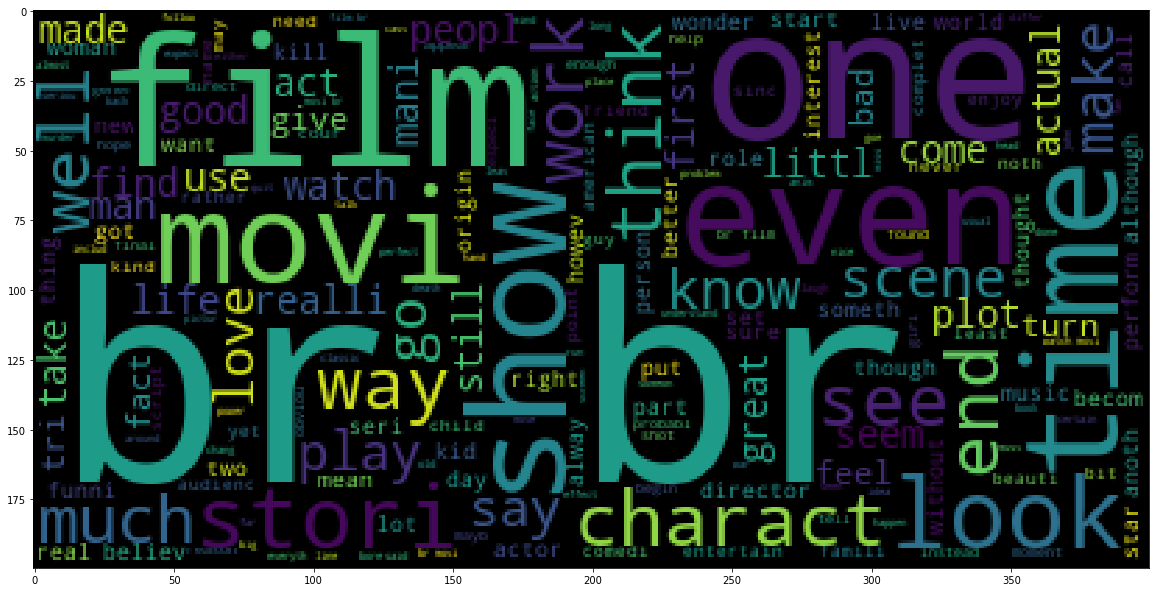

In [63]:
# Creating a list of ham data only to analyse
imdb_list = df_freq["review"][df_freq.label.isin([0])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for negative
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

In [64]:
##### Histogram Positive Train & Test set post feature selection 

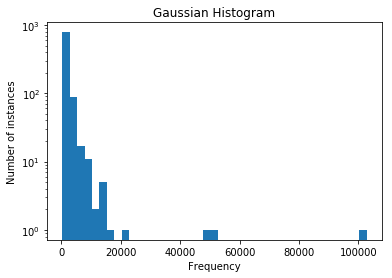

In [65]:
# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words= 'english', analyzer = 'word')
hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin([1])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis = 0).tolist()
binwidth = 2500
plt.hist(data, bins = range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

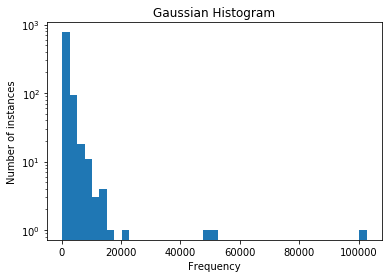

In [66]:
#### Histogram Negative Train & Test set post feature selection 

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin([0])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()


# Phase 4 Hypothesis testing  and Feature Selection

In [67]:
# Cleaning Unlabelled data

imdb_unsup['review'] = rem_sw(imdb_unsup['review'])
imdb_unsup['review'] = rem_punc(imdb_unsup['review'])
imdb_unsup['review'] = lemma(imdb_unsup['review'])
imdb_unsup['review'] = stemma(imdb_unsup['review'])

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [68]:

# Vectorizing unlabelled reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(imdb_unsup.review)

# Creating a dataframe for the high frequency words for unlabelled reviews set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T

# Removing high frequency and low frequency data for more accuracy
word_list = df_freq.nlargest(100, 'frequency').index
word_list = word_list.append(df_freq.nsmallest(43750, 'frequency').index)

# Removing unwanted words based on word_list from unlabelled data
count = 0
for sentence in imdb_unsup['review']:
    sentence = [word for word in sentence.lower().split() if word not in word_list]
    sentence = ' '.join(sentence)
    imdb_unsup.loc[count, 'review'] = sentence
    count+=1



In [69]:
################################## Preparing dataframe for model ##############################

# Creating df_algo dataframe which will be used for hypothesis testing
df_algo = pd.concat([imdb_train, imdb_test], keys=['train', 'test'])
df_algo = df_algo.reset_index(col_level=1).drop(['level_1'], axis=1)

# Cleaning the dataset
df_algo['review'] = rem_sw(df_algo['review'])
df_algo['review'] = rem_punc(df_algo['review'])
df_algo['review'] = lemma(df_algo['review'])
df_algo['review'] = stemma(df_algo['review'])



C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [70]:
df_algo.head()

,level_0,file,label,review
0,train,6844_1.txt,0,prison cell four prison carrer young compani d...
1,train,7290_10.txt,1,creator film made attempt introduc realiti plo...
2,train,2740_1.txt,0,mayb seen one mani crime flick mayb take right...
3,train,10094_1.txt,0,could good film abl watch hand held camera bou...
4,train,6150_7.txt,1,japan anim uniqu freedom anim tend abl come mo...


In [71]:
##### Removing non feature words 

# Creating the feature word_list
# Selecting 14440 feature selected words based on 80-20 rule
word_list = get_feature(df_algo[['review', 'label']], 14440)

# Removing non prefered words from training and test combined data
count = 0
for sentence in df_algo['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    df_algo.loc[count, 'review'] = sentence
    count+=1

In [72]:
####### Splitting with feature selection data a

# Vectorising the required data
vect_algo = TfidfVectorizer(stop_words='english', analyzer='word')
vect_algo.fit(df_algo.review)
Xf_train = vect_algo.transform(df_algo[df_algo['level_0'].isin(['train'])].review)
Xf_test = vect_algo.transform(df_algo[df_algo['level_0'].isin(['test'])].review)

# Encoding target data
# Creating an object and fitting on target strings
le = LabelEncoder()
yf_train = le.fit_transform(df_algo[df_algo['level_0'].isin(['train'])].label)
yf_test = le.fit_transform(df_algo[df_algo['level_0'].isin(['test'])].label)

# Phase 5 Model Building

In [73]:
###### Naive Bayes 

# Fit the Naive Bayes classifier model to the object
clf = MultinomialNB()
clf.fit(Xf_train, yf_train)

# predict the outcome for testing data
predictions = clf.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)
print("Observation: Naive Bayes Classification gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: Naive Bayes Classification gives an accuracy of 50.87% on the testing data


In [79]:
#######  DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(Xf_train, yf_train)


y_pred = tree.predict(Xf_test)

accuracy = accuracy_score(yf_test, y_pred)
print("Observation: DecisionTreeClassifier gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: DecisionTreeClassifier gives an accuracy of 50.04% on the testing data


In [82]:
##### RandomForestClassifier

rf = RandomForestClassifier(n_estimators=5)
rf.fit(Xf_train, yf_train)
y_pred = rf.predict(Xf_test)

accuracy = accuracy_score(yf_test, y_pred)
print("Observation: RandomForestClassifier gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: RandomForestClassifier gives an accuracy of 49.76% on the testing data


In [76]:
##### Using K-means to create two clusters  

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(imdb_unsup.review)
 
# Creating a k-means object and fitting it to target variable
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
 
# Visualising the 2 clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 worst
 wast
 bore
 laugh
 poor
Cluster 1:
 beauti
 famili
 alway
 excel
 differ


In [75]:
# Prediction for test set using Kmeans clusters
Y = vectorizer.transform(imdb_test.review)
prediction = model.predict(Y)

# Actual results of test sets for comparison
le = LabelEncoder()
y = le.fit_transform(imdb_test.label)

# check the accuracy of the model
accuracy = accuracy_score(y, prediction)
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("Observation: The unsupervised learning gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: The unsupervised learning gives an accuracy of 50.04% on the testing data
